<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/keras_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolutional Neural Networks


We will demonstrate CNN training and application using Keras. In this lesson the Cifar-10 image set is used to classify images into ten different classes.

The imports which are neccesary:

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
from keras import datasets, layers, models
from keras import utils
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD

Classes are labelled in the Cifar-10 image set. Here are the class labels:

In [30]:
class_labels = [
    "airplane", # 0
    "car",      # 1
    "bird",     # 2
    "cat",      # 3
    "deer",     # 4
    "dog",      # 5
    "frog",     # 6
    "horse",    # 7
    "ship",     # 8
    "truck"     # 9
]
num_classes = len(class_labels)

# Common functions

First we define some functions which are used for the following slightly different models.

In [3]:
# load train and test dataset of Cifar-10
def load_dataset():
    # load the Cifar-10 dataset and prepare labels
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY)     # convert class vector to binary (0/1) matrix
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert RGB integers of an image to floats between 0-1
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# plot diagnostic learning curves and optionaly save to file
def summarize_diagnostics(history, filename=None):
    # if file name given curves are saved to file and not displayed on screen
    fig, ax = plt.subplots(2, 1, figsize=(6, 8))
    # plot loss
    #plt.subplot(211)
    #plt.title('Cross Entropy Loss')
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue', label='train')
    ax[0].plot(history.history['val_loss'], color='orange', label='test')
    ax[0].legend()
    # plot accuracy
    #plt.subplot(212)
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history.history['accuracy'], color='blue', label='train')
    ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
    ax[1].legend(loc=4)
    plt.subplots_adjust(wspace=0.5)
    if filename:
        # save plot to file
        pyplot.savefig(filename + '_plot.png')
        pyplot.close()

# save model for later use
def save_model(model, name):
    # Save neural network structure
    model_structure = model.to_json()
    f = open(name+".json", "w")
    f.write(model_structure)
    # Save neural network's trained weights
    model.save_weights(name+".weights.h5")

def load_model(name):
    # Load the json file that contains the model's structure
    f = open(name+".json")
    my_model_structure = f.read()
    # Recreate the Keras model object from the json data
    my_model = model_from_json(my_model_structure)
    # Re-load the model's trained weights
    my_model.load_weights(name+".weights.h5")
    return my_model

# Preparing data

Cifar-10 data set contains 60_000 images, 6000 images for the 10 different classes. The size of the RGB images is 32 x 32 pixel.
It may take one minute to dowload the images from the internet, dependig on the internet bandwith.

In [4]:
# Load data set
x_train, y_train, x_test, y_test = load_dataset()
# Normalize data set to 0-to-1 range
x_train, x_test = prep_pixels(x_train, x_test)
print(f"Image size: {x_train.shape[1:]}\nTrain size: {x_train.shape[0]}\nTest  size: {x_test.shape[0]}")
print(f"\nImage counts by classes\n{'*'*25}\nLabel         Train  Test\n{'*'*25}")
for i, name in enumerate(class_labels):
    print(f"{name:10s}  {int(np.sum(y_train[:,i])):6d} {int(np.sum(y_test[:,i])):6d}")

170498071/170498071 [==============================] - 13s 0us/step
Image size: (32, 32, 3)
Train size: 50000
Test  size: 10000

Image counts by classes
*************************
Label         Train  Test
*************************
airplane      5000   1000
car           5000   1000
bird          5000   1000
cat           5000   1000
deer          5000   1000
dog           5000   1000
frog          5000   1000
horse         5000   1000
ship          5000   1000
truck         5000   1000


# Random images from test set

Let us examine few images from the test set. Start the next block several times to explore more random subsets.

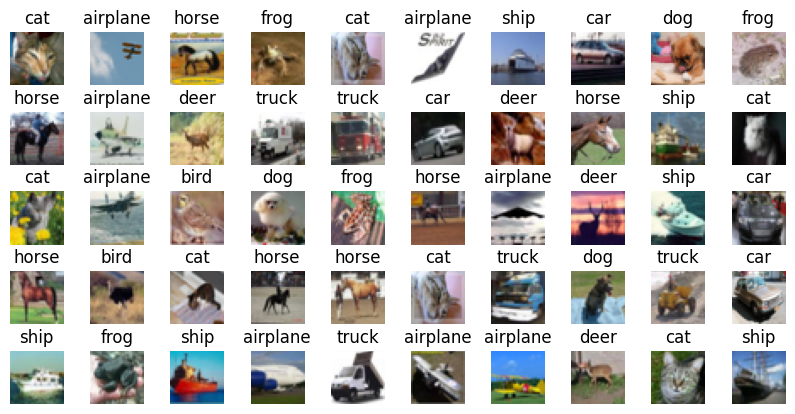

In [5]:
# generate random indices
rows = 5; cols = 10
rand_ind = np.random.randint(0, high=1000, size=rows*cols, dtype=int)
fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    img_ind = rand_ind[i]
    axes[i].imshow(x_test[img_ind])
    axes[i].set_title(class_labels[np.argmax(y_test[img_ind])])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

# Extra test images without labels

We prepared some images without label for testing purpose.


In [33]:
!rm *.png *.jpg *.jpeg
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/airplane.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/car.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/cat.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/deer.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/dog.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/frog.jpeg
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/horse.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/pingvin
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/ship.png
!wget -q https://github.com/OSGeoLabBp/tutorials/tree/master/english/machine_learning/lessons/data/truck.png

rm: cannot remove '*.jpg': No such file or directory


You can upload any image (square shape) for checking the model into *content* folder with *.png* or *.jpg* or *.jpeg* extension.

In [31]:
# collecting images from local folder
import glob
#imgs = glob.glob("*.png") + glob.glob("*.jpg") + glob.glob("*.jpeg")
imgs = ["airplane.png", "car.png", "cat.png", "deer.png", "dog.png", "frog.jpeg", "horse.png", "pingvin.png", "ship.png", "truck.png"]
#num_imgs = len(imgs)
print(imgs)

['airplane.png', 'car.png', 'cat.png', 'deer.png', 'dog.png', 'frog.jpeg', 'horse.png', 'pingvin.png', 'ship.png', 'truck.png']


Preparing images for testing

In [35]:
list_of_imgs = np.zeros((len(imgs), 32, 32, 3), dtype=np.float32)
for i, img_name in enumerate(imgs):
    print(i, img_name)
    try:
        img = image.load_img(img_name, target_size=(32, 32), interpolation="bicubic")
        image_to_test = image.img_to_array(img)
        list_of_imgs[i] = image_to_test
    except:
        print(f"Error: {img_name}")
list_of_imgs /= 256

0 airplane.png
Error: airplane.png
1 car.png
Error: car.png
2 cat.png
Error: cat.png
3 deer.png
Error: deer.png
4 dog.png
Error: dog.png
5 frog.jpeg
Error: frog.jpeg
6 horse.png
Error: horse.png
7 pingvin.png
Error: pingvin.png
8 ship.png
Error: ship.png
9 truck.png
Error: truck.png


1/1 [==============================] - 0s 220ms/step


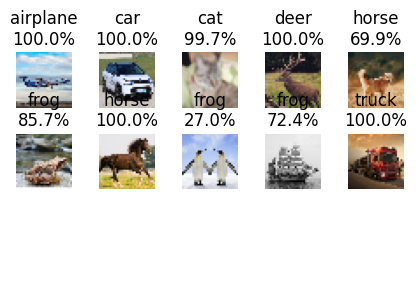

In [16]:
def extra_test(model, list_og_imgs):
    pred = model.predict(list_of_imgs)
    pred_classes = np.argmax(pred, axis=1)
    num_imgs = list_of_imgs.shape[0]
    rows = num_imgs // 5 + 1; cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(cols,rows))
    axes = axes.ravel()

    for i in np.arange(0, rows * cols):
        if i < num_imgs:
            axes[i].imshow(list_of_imgs[i])
            axes[i].set_title(f"{class_labels[pred_classes[i]]}\n{pred[i,pred_classes[i]]:.1%}")
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)

 # First model

In [6]:
# Create a model and add layers
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
%%time
epochs = 40
# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/40
782/782 [==============================] - 18s 15ms/step - loss: 1.5457 - accuracy: 0.4343 - val_loss: 1.2018 - val_accuracy: 0.5648
Epoch 2/40
782/782 [==============================] - 9s 11ms/step - loss: 1.1522 - accuracy: 0.5892 - val_loss: 0.9940 - val_accuracy: 0.6472
Epoch 3/40
782/782 [==============================] - 7s 9ms/step - loss: 0.9777 - accuracy: 0.6540 - val_loss: 0.8483 - val_accuracy: 0.7022
Epoch 4/40
782/782 [==============================] - 7s 9ms/step - loss: 0.8693 - accuracy: 0.6962 - val_loss: 0.7996 - val_accuracy: 0.7226
Epoch 5/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7988 - accuracy: 0.7201 - val_loss: 0.7530 - val_accuracy: 0.7389
Epoch 6/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7424 - accuracy: 0.7419 - val_loss: 0.7075 - val_accuracy: 0.7615
Epoch 7/40
782/782 [==============================] - 6s 8ms/step - loss: 0.6950 - accuracy: 0.7576 - val_loss: 0.6545 - val_accuracy: 0.7731
Epo

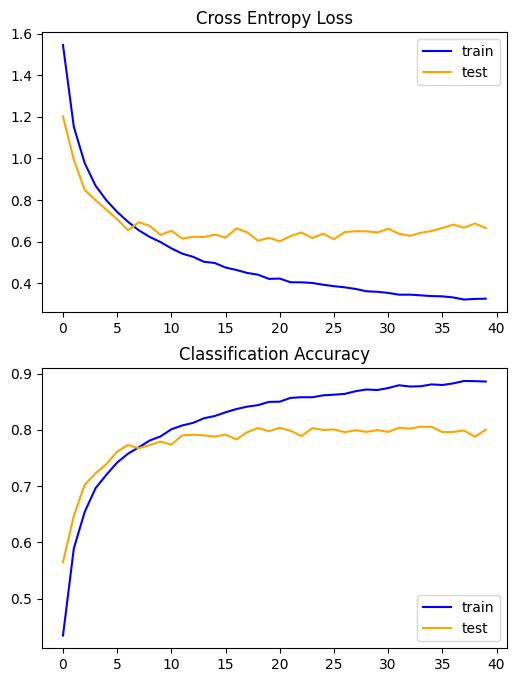

In [8]:
summarize_diagnostics(history)

In [9]:
# save the model
save_model(model, "first")

# Second try

In [ ]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Checking the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_21 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_22 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                      

In [ ]:
%%time
epochs = 10
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 16s 15ms/step - loss: 1.7381 - accuracy: 0.4024 - val_loss: 1.2325 - val_accuracy: 0.5543
Epoch 2/10
782/782 [==============================] - 11s 15ms/step - loss: 1.1788 - accuracy: 0.5792 - val_loss: 1.1143 - val_accuracy: 0.6063
Epoch 3/10
782/782 [==============================] - 11s 15ms/step - loss: 0.9930 - accuracy: 0.6486 - val_loss: 0.9876 - val_accuracy: 0.6568
Epoch 4/10
782/782 [==============================] - 12s 16ms/step - loss: 0.8945 - accuracy: 0.6878 - val_loss: 0.7629 - val_accuracy: 0.7369
Epoch 5/10
782/782 [==============================] - 11s 14ms/step - loss: 0.8145 - accuracy: 0.7170 - val_loss: 0.7362 - val_accuracy: 0.7417
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.7609 - accuracy: 0.7354 - val_loss: 0.8246 - val_accuracy: 0.7255
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.7150 - accuracy: 0.7517 - val_loss: 0.6710 - val_accuracy:

In [ ]:
# save the model
save_model(model, "second")

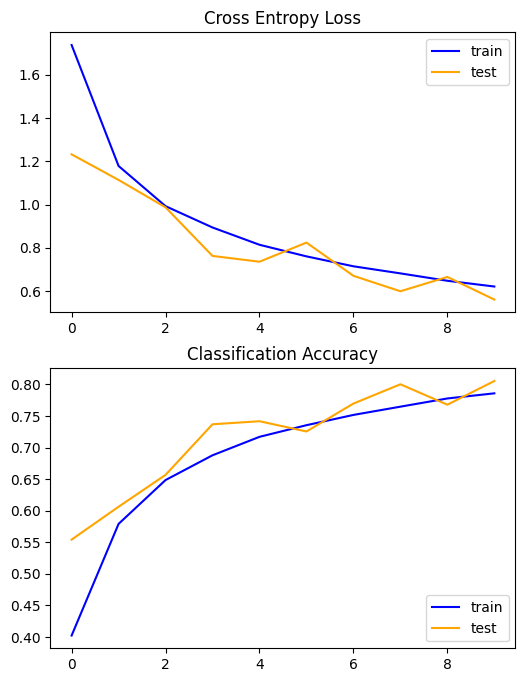

In [ ]:
summarize_diagnostics(history)

In [ ]:
# Making the Predictions
pred = model.predict(x_test)

# Converting the predictions into label index
pred_classes = np.argmax(pred, axis=1)

# Plotting the Actual vs. Predicted results
rows = 2; cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(cols,rows))
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_labels[np.argmax(y_test[i])], class_labels[pred_classes[i]]))
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

NameError: name 'model' is not defined

# Third try

In [ ]:
# define cnn model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
epochs = 10
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)
    # evaluate model
#_, acc = model.evaluate(testX, testY, verbose=0)
#print('> %.3f' % (acc * 100.0))

Epoch 1/10
782/782 [==============================] - 10s 11ms/step - loss: 2.0034 - accuracy: 0.2530 - val_loss: 1.6740 - val_accuracy: 0.3971
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 1.6605 - accuracy: 0.3855 - val_loss: 1.4859 - val_accuracy: 0.4644
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 1.5166 - accuracy: 0.4429 - val_loss: 1.3616 - val_accuracy: 0.5130
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 1.4227 - accuracy: 0.4808 - val_loss: 1.2829 - val_accuracy: 0.5427
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 1.3414 - accuracy: 0.5127 - val_loss: 1.2634 - val_accuracy: 0.5417
Epoch 6/10
782/782 [==============================] - 8s 10ms/step - loss: 1.2755 - accuracy: 0.5414 - val_loss: 1.1621 - val_accuracy: 0.5871
Epoch 7/10
782/782 [==============================] - 8s 10ms/step - loss: 1.2137 - accuracy: 0.5639 - val_loss: 1.1208 - val_accuracy: 0.6044

In [ ]:
# save the model
save_model(model, "third")

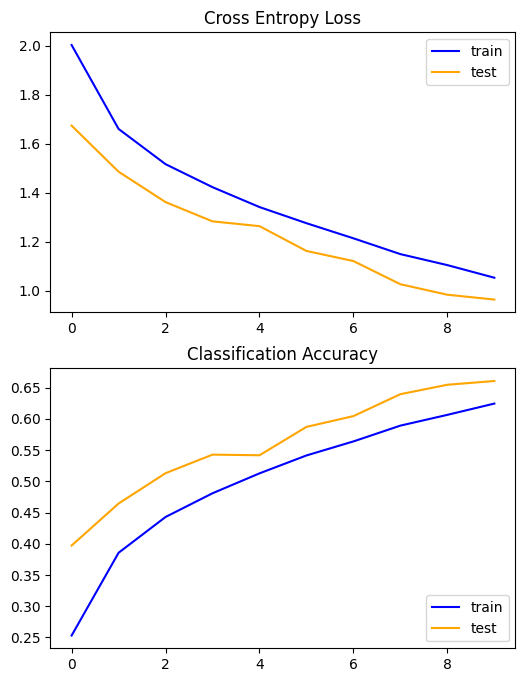

In [ ]:
summarize_diagnostics(history)